# Classifying Crime: San Francisco Open Data
Crime data from 2003 to early 2015 has been published by the city/county of San Francisco (herein SF) by SF Opendata. Using indicators of time, location, and responding police districts, the task was to classify a reported crime.

## Useful Libraries, Scripts, and Other Imports

In [3]:
%matplotlib inline
import crime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Loading the Data - Cleaning and Recoding

We first load and clean the data - replacing extraneous or erroneous longitude and latitude values with median locations based upon responding police district, breaking the timestamps into individual columns, turning category labels into category numbers for ease of interacting with models, and dropping redundant columns that were otherwise recoded.

In [4]:
train = crime.load_cleaned_train()
test = crime.load_cleaned_test()

print train.info()
print test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 29 columns):
Category          878049 non-null object
X                 878049 non-null float64
Y                 878049 non-null float64
Year              878049 non-null int64
Month             878049 non-null int64
Day               878049 non-null int64
Hour              878049 non-null int64
Minute            878049 non-null int64
BogusReport       878049 non-null bool
NBogusReport      878049 non-null bool
DoW               878049 non-null int64
Morning           878049 non-null int64
Afternoon         878049 non-null int64
Evening           878049 non-null int64
Night             878049 non-null int64
PdD               878049 non-null int64
PdD_0             878049 non-null float64
PdD_1             878049 non-null float64
PdD_2             878049 non-null float64
PdD_3             878049 non-null float64
PdD_4             878049 non-null float64
PdD_5             878049 non-null fl

During exploration, it was found that mapping crimes yielded a gridded type pattern when overlayed with the a map of San Francisco. Upon further inspection of the address column, we decided to add a flag to the data which captures whether or not a crime occured on a street corner. Further, we also measured across all years the most prevalent address locations on which crimes were reported, and encode the top two streets reported. The first street - the street on which most reports are addressed - turns out to be the street on which the courthouse is located within the city. Below, see an example of some crimes which are mapped. Note the number of crimes which appear to occur on a corner.

In [56]:
#get the map, downloaded to the working directory
mapdata = np.loadtxt('sf_map_copyright_openstreetmap_contributors.txt')
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

def showMap():
    """
    Show the map of San Francisco
    """
#     plt.axis(lon_lat_box)
    plt.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                  extent=lon_lat_box, 
                  aspect=asp)

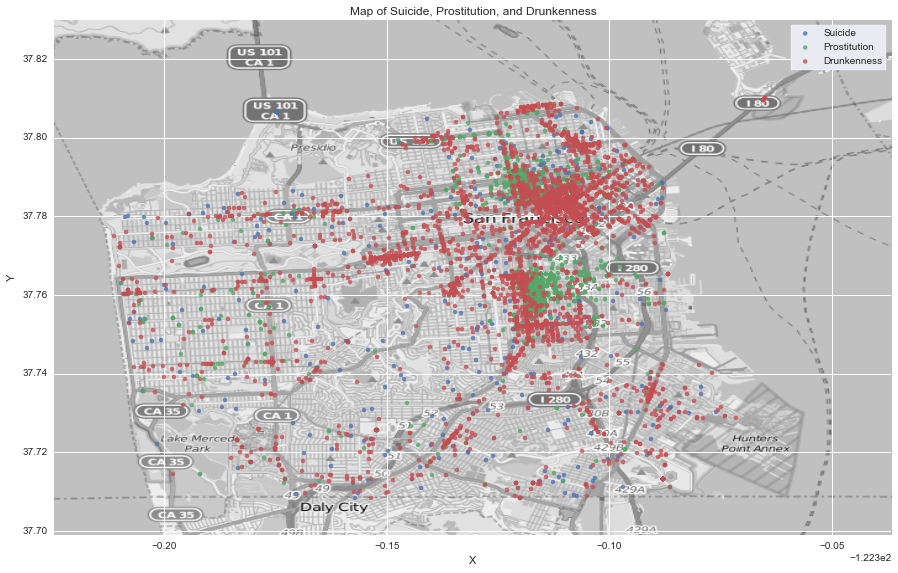

In [57]:
#Mapping an illustration of crime across all years to show the relative
#locations of interesting quantities, and the prevalence of 'corner crime'
#gridding.

plt.figure(figsize=(15,15))

#map suicide, prostitution, and drunkenness
sns.regplot(train[train.Category == 'SUICIDE'].X, train[train.Category == 'SUICIDE'].Y, fit_reg=False)
sns.regplot(train[train.Category == 'PROSTITUTION'].X, train[train.Category == 'PROSTITUTION'].Y, fit_reg=False)
sns.regplot(train[train.Category == 'DRUNKENNESS'].X, train[train.Category == 'DRUNKENNESS'].Y, fit_reg=False)

showMap()
plt.legend(['Suicide', 'Prostitution', 'Drunkenness'], frameon=True)
plt.title('Map of Suicide, Prostitution, and Drunkenness')

## More Closely Examining SF Crime
With the emergence of SF as a technology haven within the last 12 years, crime has changed character and flavor within the city. The changing face of the SF population has brough with it a due amount of unrest. To explore how this manifested within the dataset, we look at the spatial, temporal, and the spatiotemportal relationships.

### Temporal

HYPOTHESIS: The major types of crime have likely stayed the same, but the most significant crimes today are different from those in the early 2000s.

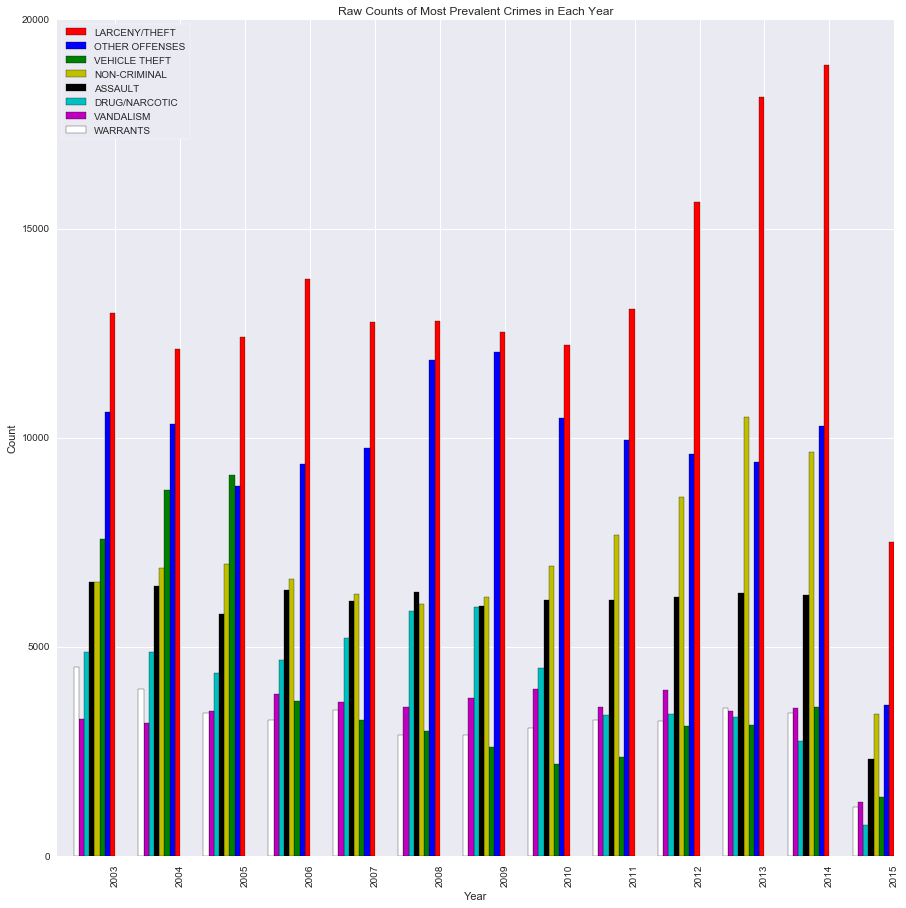

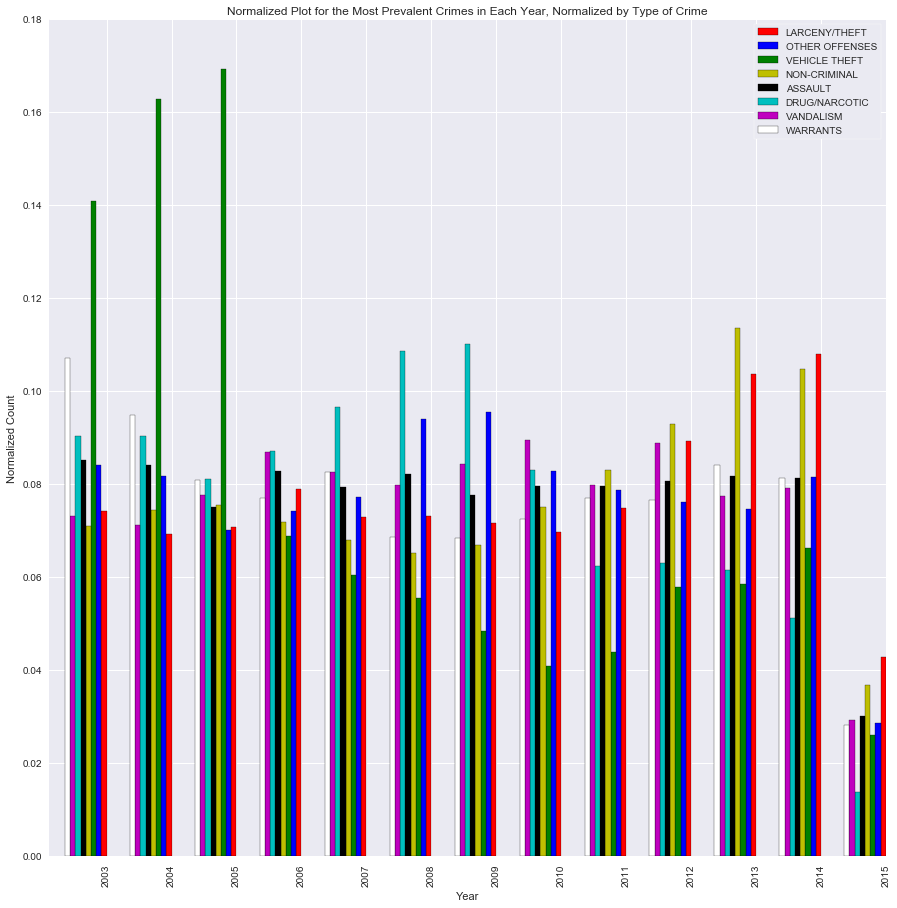

In [20]:
#set up for plotting, let's identify the top crimes in each year
count = 0
top_crime = []
colors = ['r','b','g','y','k','c','m','w','r','b','g','y','k','c','m','w'] #to make sure cover all crimes
years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
for year in years:
    cats = train.Category[train.Year==year].value_counts()[0:5]
    for category in cats.index:
        if category not in top_crime:
            top_crime.append(category)

#raw counts of those top crimes
plt.figure(figsize=(15,15))
for crime in top_crime:
    ax = train.Year[(train.Category==crime)].value_counts(sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime, loc='best', frameon=True)
plt.title('Raw Counts of Most Prevalent Crimes in Each Year')
plt.xlabel('Year')
plt.ylabel('Count')

#normalized counts across the years for each of those top crime
count = 0
plt.figure(figsize=(15,15))
for crime in top_crime:
    ax = train.Year[train.Category==crime].value_counts('normalize', sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime, loc='best', frameon=True)
plt.title('Normalized Plot for the Most Prevalent Crimes in Each Year, Normalized by Type of Crime')
plt.xlabel('Year')
plt.ylabel('Normalized Count')

TAKEAWAY: This hypothesis seems to hold true. There has been a rise in crime over the last several years, but the flavor of crime has shifted - there is proportionally more larceny and vehicle crime than there used to be, vehicle theft has plummetted, and the spike in drugs and narcotics is no longer evident.

Similarly, we wonder whether the time of the year holds any meaning to the types of crime which might be evident. Over the course of the months:

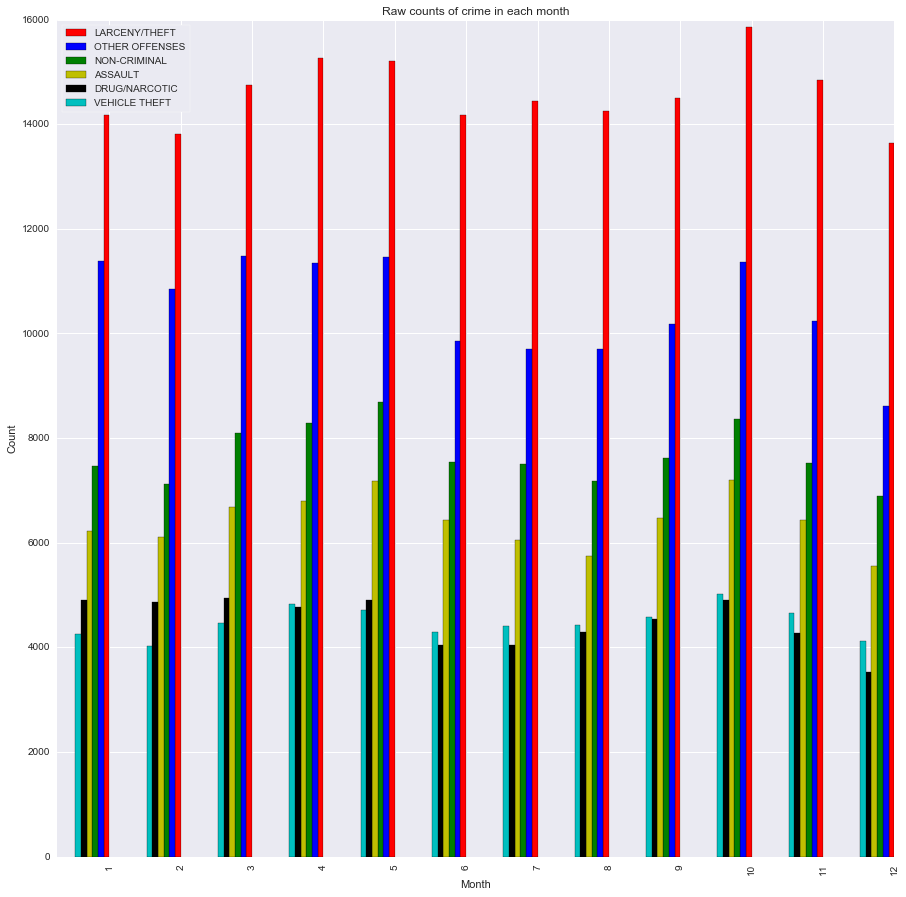

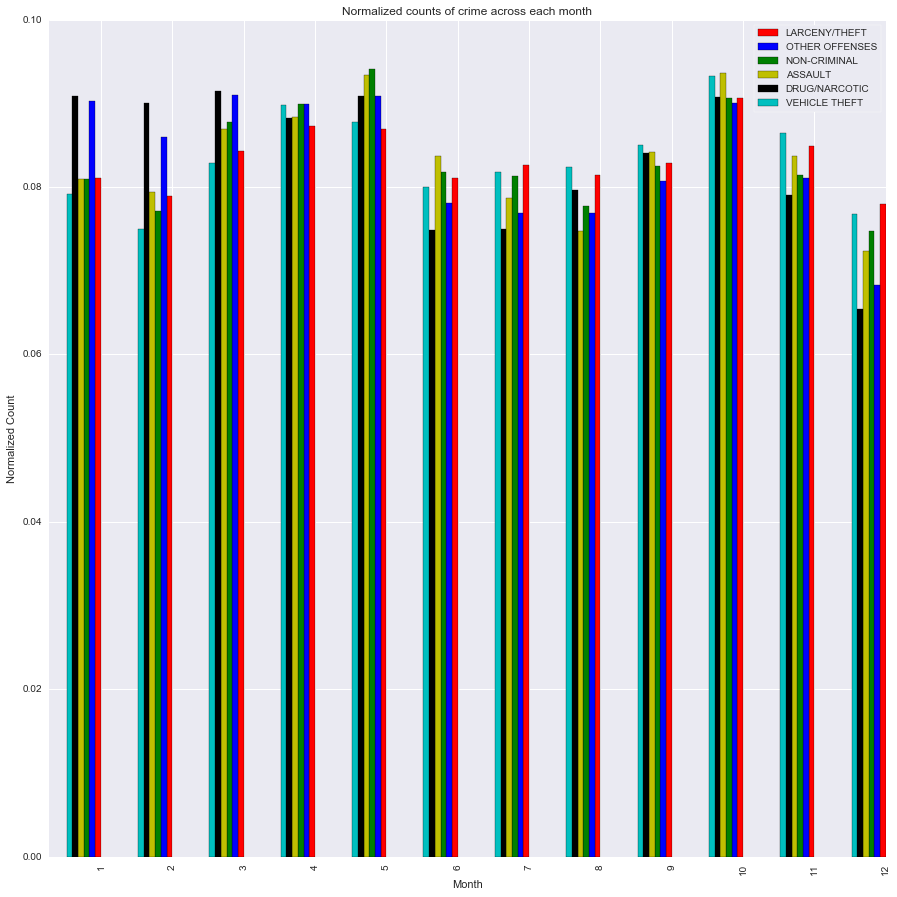

In [32]:
#taking a look at crime in each month
count = 0
top_crime = []
colors = ['r','b','g','y','k','c','m','w','r','b','g','y','k','c','m','w']
for month in train.Month.unique():
    cats = train.Category[train.Month==month].value_counts()[0:5]
    for category in cats.index:
        if category not in top_crime:
            top_crime.append(category)

plt.figure(figsize=(15,15))
for crime in top_crime:
    train.Month[train.Category==crime].value_counts(sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime, loc='best', frameon=True)
plt.title('Raw counts of crime in each month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.figure(figsize=(15,15))
count = 0
for crime in top_crime:
    train.Month[train.Category==crime].value_counts('normalize',sort=False).plot(kind='bar', position=count+1, color=colors[count], width=0.08, align='center')
    count += 1
plt.legend(top_crime, loc='best', frameon=True)
plt.title('Normalized counts of crime across each month')
plt.xlabel('Month')
plt.ylabel('Normalized Count')

Seasonal effects seem to be low, at best with spring and fall seemingly more crime-filled than other seasons. When looking at San Francisco weather patterns, we might be able to claim that given the moderate climate, crime may not be dissuaded by particularly bad weather. Though one might think that tourist season may see a general rise in crime, this does not necessarily seem to be the case as evidenced in the data. Some reasons for this might include a heightened police presence during these months, more temporary job vacancies, etc. When planning for temporal predictors, there does appear to be some signal in crime and months/years - these may be used in the final model.

HYPOTHESIS: Though seasonal changes might not appear significant, what about day to day? Certain types of crime will be more likely to be reported at unique times of day which may be mapped to either the time of crime discovery, or the time at which the perpetrator may have been caught.

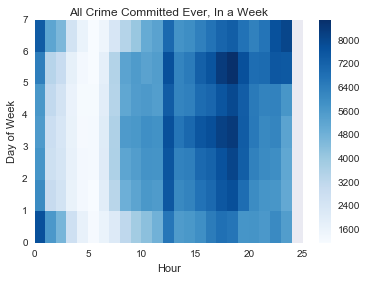

In [28]:
#report density plot for all crime reports as a function of day of week (1-7) and time of day (0-24)
grouped = train.groupby(['DoW', 'Hour']).Category.count()
data = grouped.values.reshape(7,24)
plt.pcolor(data,cmap=plt.cm.Blues)
plt.title('All Crime Committed Ever, In a Week')
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.colorbar()

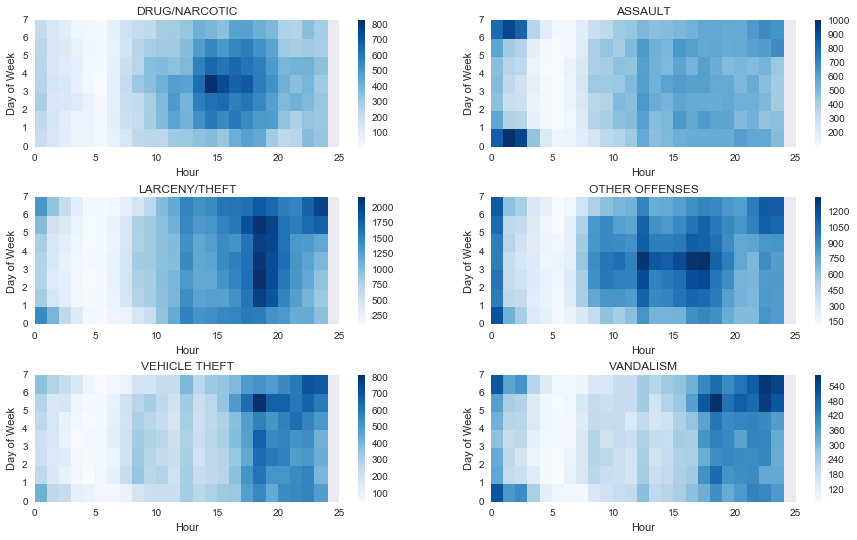

In [45]:
# report density plots for a variety of crimes
time_dep_hyp = ['DRUG/NARCOTIC', 'ASSAULT', 'LARCENY/THEFT', 'OTHER OFFENSES', 'VEHICLE THEFT', 'VANDALISM']
index = 521
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace = 0.4)
for crime in time_dep_hyp:
    grouped = train[train.Category==crime].groupby(['DoW', 'Hour']).Category.count()
    data = grouped.values.reshape(7,24)
    plt.subplot(index)
    plt.pcolor(data, cmap=plt.cm.Blues)
    plt.title(crime)
    plt.xlabel('Hour')
    plt.ylabel('Day of Week')
    plt.colorbar()
    index += 1

TAKEAWAY: There does seem to be a strong relationship between time of day and the type of crime, with a secondary day of week relationship. It certainly seems like 5AM is a low point in crime reports, with midday, early evening, or midnight being a secondary peak in the day.

HYPOTHESIS: Crimes are timestamped to the minute, but how precise are the reported times? There will likely be a large number of crimes reported with the timestamp rounded to the nearest half hour or hour.

12:00    22351
00:01    21831
18:00    19330
17:00    16960
20:00    16294
dtype: int64


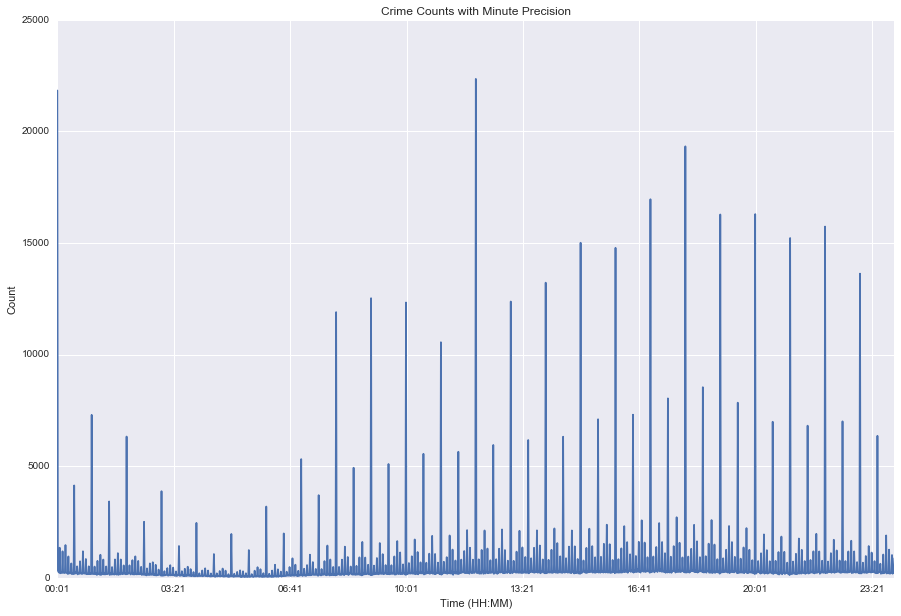

In [81]:
#number of reports as a function of time of day
plt.figure(figsize=(15,10))

precise_time = train.apply(lambda x: '{:02d}:{:02d}'.format(x.Hour, x.Minute), axis=1)
print precise_time.value_counts()[:5]

precise_time.value_counts().sort_index().plot()
plt.title('Crime Counts with Minute Precision')
plt.xlabel('Time (HH:MM)')
plt.ylabel('Count')

TAKEAWAY: There are an unusually large number of reports filed at 00:01 and 12:00 compared to the times around them. It is possible that these times were used as filler when the exact time of a crime was unknown or unimportant.

### Spatial
Now, let's look at some of those spatial relationships...

HYPOTHESIS: Different types of crime will localize in unique, dense, areas.

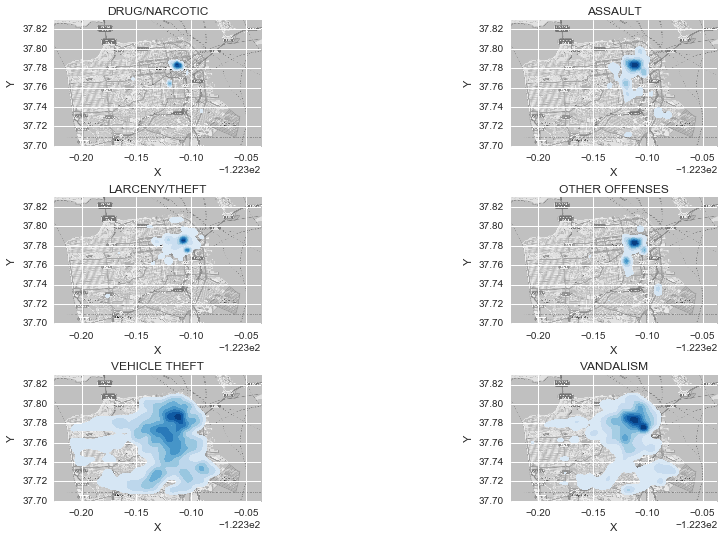

In [64]:
#Density maps of crime types
index = 521
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace = 0.4)
for crime in time_dep_hyp:
    crime2plot = train.loc[train.Category == crime]
    plt.subplot(index)
    sns.kdeplot(crime2plot.X, crime2plot.Y, shade=True, shade_lowest=False, cmap='Blues', legend=True)
    showMap()
    plt.title(crime)
    index += 1

TAKEAWAY: Some of the crimes have a clear spatial relationship - and most crimes seem to concentrate within one particular area. The spread of crimes is also revealing - while other offenses happen just about everywhere, something like drug/narcotic crimes. Location will certainly factor into a model of interest.

### Spatiotemporal
Given that the face of crime has changed, and there is certainly a relationship between location and crime type, we determine whether these factos together may yield some interesting relationships which could be exploited in model predictors.

HYPOTHESIS: Some crime locations have shifted over time, though potentially minimally, whereas others may be relatively new or have completely died as gentrification, tourism, and the technology boom took over the city.

<function __main__.plotByYear>

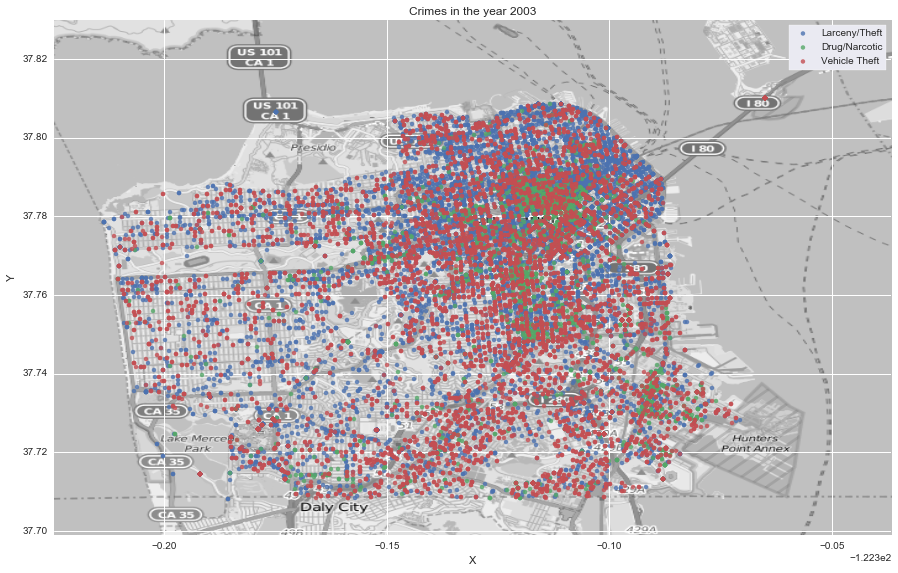

In [63]:
#Slider widget for crimes by year
def plotByYear(year):
    """
    Plot crimes from the given year
    Unfortunately, seem to require (ab)using global variables
    """
    plt.figure(figsize=(15,15))
    df = train[train.Year == year]
    for category in ['LARCENY/THEFT', 'DRUG/NARCOTIC', 'VEHICLE THEFT']:
        crime2plot = df[df.Category == category]
        sns.regplot(crime2plot.X, crime2plot.Y, fit_reg=False)
    showMap()
    plt.legend(['Larceny/Theft', 'Drug/Narcotic', 'Vehicle Theft'], frameon=True)
    plt.title('Crimes in the year {}'.format(year))

year_slider = widgets.IntSlider(min=train.Year.min(), max=train.Year.max(), value=train.Year.min())
widgets.interact(plotByYear, year=year_slider)

TAKEAWAY: This confirms both of the spatial and temporal pieces that have already been discussed, but also shows that there has been some mobility over time on crime, at least in these categories. Using spatial and temporal classifiers together will be critical to developing a robust model.

## Classifying Crime
Given the relationships which were discovered, or assumed, we want to develop a set of predictors which have demonstrable relationships with crime types in order to test and train our model. The three model types which seem to be appropriate given the type of data being used are the Logistic Regression, Random Forest, and K Nearest Neighbors.